In [1]:
import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import yaml
import glob, os
import loadcoraldata_utils as coralutils
import json
import importlib
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from osgeo import gdal
from sklearn.manifold import TSNE

from matplotlib import colors
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


In [2]:
jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
consolclass_count = dict((k, 0) for k in json_data["VedConsolidated_ClassDict"])

# cmap = colors.ListedColormap(['xkcd:red', 'xkcd:orange', 'xkcd:grey', 'xkcd:pink', 'xkcd:sky blue', 'xkcd:forest',
#                              'xkcd:tan', 'xkcd:olive', 'xkcd:blue', 'xkcd:white'])
cmap = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                              'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])

mosaics = [1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,20,21,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]

for mosaic_count in mosaics:
    print("Mosaic Count: ", mosaic_count)
    imgpath = 'C:/NeMO-Net Data/processed_Fiji_files/mosaiced_' + str(mosaic_count).zfill(3) + '.TIF'
    truthpath = 'C:/NeMO-Net Data/processed_Fiji_files/truth_classes_wcldMask_' + str(mosaic_count).zfill(3) + '.TIF'
    output_trainpath = '../Images/Fiji_RGB_Patches_512/'
    output_trainrefpath = '../Images/Fiji_RGBRef_Patches_512/'
    output_trainfilename = 'rastertrain.txt'
#     imgpath = 'F:/Images/processed_Fiji_files/mosaiced_' + str(mosaic_count).zfill(3) + '.TIF'
#     truthpath = 'F:/Images/processed_Fiji_files/truth_classes_wcldMask_' + str(mosaic_count).zfill(3) + '.TIF'
#     output_trainpath = 'F:/Images/Fiji_RGB_Patches_256/'
#     output_trainrefpath = 'F:/Images/Fiji_RGBRef_Patches_256/'
#     output_trainfilename = 'rastertrain.txt'

    Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
    Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
    Fiji.Consolidate_classes(newclassdict=json_data["VedConsolidated_ClassDict"], transferdict=json_data["L32VedConsolidated_Dict"])
    
    max_R = np.max(Fiji.image[:,:,4])
    max_G = np.max(Fiji.image[:,:,2])
    max_B = np.max(Fiji.image[:,:,1])
    std_R = np.std(Fiji.image[:,:,4])
    std_G = np.std(Fiji.image[:,:,2])
    std_B = np.std(Fiji.image[:,:,1])
    mosaic_std = 1/255*np.asarray([200,200,200], dtype=np.float32)
    
    print("Outputing Training...")
    Fiji.export_segmentation_map(output_trainpath, output_trainrefpath, 
                                        output_trainfilename, image_size=512, N=10, lastchannelremove=False, 
                                        subdir=True, cont=True, consolidated = True, 
                                        mosaic_mean = [0,0,0], mosaic_std = mosaic_std, 
                                        bandstoexport= [5,3,2], exporttype=gdal.GDT_Byte, label_cmap=cmap)
    print("\n")
    # print("Outputing Validation...")
    # Fiji.export_segmentation_map(output_validpath, output_validrefpath, 
    #                                     output_validfilename, image_size=256, N=5, lastchannelremove=False, 
    #                                     subdir=True, cont=True, consolidated = True,
    #                                     mosaic_mean = mosaic_mean, mosaic_std = mosaic_std)
    
    for k in Fiji.consolidated_class_dict:
        consolclass_count[k] = consolclass_count[k] + Fiji.consolclass_count[k]
        
total_pixels = np.sum([consolclass_count[k] for k in Fiji.consolidated_class_dict])
consolclass_weights = dict((k, total_pixels/consolclass_count[k]) for k in Fiji.consolidated_class_dict)
for k in consolclass_weights:
    if consolclass_weights[k] == float("inf"):
        consolclass_weights[k] = 0

Mosaic Count:  1


./utils\loadcoraldata_utils.py:211: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  2
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  3
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  4
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  5
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  6
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  10
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  11
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  12
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  13
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  14
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  15
Outputing Training...
7 of 9 total classes found and saved


Mosaic Count:  16
Outputing Training...
7 of 9 total classes found and save

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in long_scalars


In [5]:
with open("init_args - Fijitest.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])
if train_loader.color_mode == 'rgb':
    num_channels = 3
elif train_loader.color_mode == '8channel':
    num_channels = 8
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean =250*np.ones(num_channels)
pixel_std = 250*np.ones(num_channels)
datagen = NeMOImageGenerator(image_shape = (y,x,num_channels),
    image_resample=True, pixelwise_center=True,
    pixel_mean=pixel_mean, pixelwise_std_normalization=True,
    pixel_std=pixel_std)

train_generator = datagen.flow_from_NeMOdirectory(output_trainpath,
    target_size=(y,x),
    color_mode=train_loader.color_mode,
    passedclasses = Fiji.consolidated_class_dict,
    class_mode = 'categorical',
    batch_size = 50,
    shuffle=True)

Found 3740 images belonging to 17 classes, split into 39 consolidated classes.
class idx startend:  [[0, 220], [220, 440], [440, 660], [660, 880], [880, 1100], [1100, 1320], [1320, 1540], [1540, 1760], [1760, 1980], [1980, 2200], [2200, 2420], [2420, 2640], [2640, 2860], [2860, 3080], [3080, 3300], [3300, 3520], [3520, 3740]]


In [6]:
jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
consolclass_count = dict((k, 0) for k in json_data["L3_ClassDict"])

mosaic_count = 3
# cmap = colors.ListedColormap(['xkcd:mauve', 'xkcd:red', 'xkcd:magenta', 'xkcd:dark yellow', 'xkcd:dried blood',
#                              'xkcd:grey', 'xkcd:pink', 'xkcd:violet', 'xkcd:navy', 'xkcd:lime', 'xkcd:orange',
#                              'xkcd:yellow', 'xkcd:sky blue', 'xkcd:tan', 'xkcd:dark brown', 'xkcd:steel',
#                              'xkcd:forest', 'xkcd:olive', 'xkcd:neon green', 'xkcd:gold',
#                              'xkcd:black', 'xkcd:greenish yellow', 'xkcd:blue', 'xkcd:white'])
cmap = colors.ListedColormap(['xkcd:red', 'xkcd:orange', 'xkcd:grey', 'xkcd:pink', 'xkcd:sky blue', 'xkcd:forest',
                             'xkcd:tan', 'xkcd:olive', 'xkcd:blue', 'xkcd:white'])
cmap_nogrey = colors.ListedColormap(['xkcd:red', 'xkcd:orange', 'xkcd:pink', 'xkcd:sky blue', 'xkcd:forest',
                             'xkcd:tan', 'xkcd:olive', 'xkcd:blue', 'xkcd:white'])
cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
grey = np.asarray(np.asarray(cmap(2)[-2::-1])*255, dtype=np.uint8)
bounds = [i+0.5 for i in range(len(cmap.colors)+1)] # assumes labels start at 1
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap.N)

imgpath = 'C:/NeMO-Net Data/processed_Fiji_files/mosaiced_001.TIF'
truthpath = 'C:/NeMO-Net Data/processed_Fiji_files/truth_classes_wcldMask_001.TIF'
# imgpath = 'F:/Images/processed_Fiji_files/mosaiced_' + str(mosaic_count).zfill(3) + '.TIF'
# truthpath = 'F:/Images/processed_Fiji_files/truth_classes_wcldMask_' + str(mosaic_count).zfill(3) + '.TIF'
# testpng = 'F:/Images/CopyLayer.png'

Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
Fiji.Consolidate_classes(newclassdict=json_data["VedConsolidated_ClassDict"], transferdict=json_data["L32VedConsolidated_Dict"])
class_indices_rev = dict((v,k) for k,v in Fiji.consolidated_class_dict.items()) #flip k,v

# df_tsne['x-tsne'] = tsne_results[:,0]
# df_tsne['y-tsne'] = tsne_results[:,1]

# Stretch RGB image
# max_R = np.max(Fiji.image[:,:,4])
# max_G = np.max(Fiji.image[:,:,2])
# max_B = np.max(Fiji.image[:,:,1])
# Fiji_RGB = np.rollaxis(np.asarray([2/max_R*Fiji.image[:,:,4], 2/max_G*Fiji.image[:,:,2], 2/max_B*Fiji.image[:,:,1]]),0,3)

# Remapping last remaining unlabeled set to something (grey in this case)
# remap = coralutils.fill_in_truthmap(testpng, cmap_nogrey, grey)
# truthmap = cv2.imread(testpng)

# fig = plt.figure(4,figsize=(10,10))
# ax = plt.subplot(111)
# ax.imshow(truthmap[...,::-1])
# plt.show()

# fig = plt.figure(5,figsize=(10,10))
# ax = plt.subplot(111)
# ax.imshow(remap[...,::-1])
# plt.show()

# Color plot of relevant area
# fig = plt.figure(1,figsize=(10,10))
# ax = plt.subplot(111)
# ax.imshow(Fiji_RGB[800:1100,3400:3800,:])
# ax.imshow(Fiji.truthimage_consolidated.astype(int)[800:1100,3400:3800], interpolation='nearest', cmap=cmap, norm=norm, alpha=0.25)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.2,
#                  box.width, box.height])
# ax.legend([mpatches.Patch(color=cmap(i)) for i in range(len(cmap.colors))],
#            ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
#           loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

# fig = plt.figure(2,figsize=(10,10))
# ax = plt.subplot(111)
# ax.imshow(Fiji.truthimage_consolidated.astype(int)[800:1100,3400:3800], interpolation='nearest', cmap=cmap, norm=norm)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.2,
#                  box.width, box.height])
# ax.legend([mpatches.Patch(color=cmap(i)) for i in range(len(cmap.colors))],
#            ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
#           loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

# fig = plt.figure(3,figsize=(10,10))
# ax = plt.subplot(111)
# ax.imshow(Fiji_RGB[800:1100,3400:3800,:])

# plt.show()

./utils\loadcoraldata_utils.py:209: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


# Data analysis stuff 

In [6]:
jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
consolclass_count = dict((k, 0) for k in json_data["L3_ClassDict"])
anchorlist = ['Terrestrial Vegetated', 'Deep Ocean Water']
    
for mosaic_count in range(11,12):
    print("Mosaic Count: ", mosaic_count)
    
    imgpath = 'F:/Images/processed_Fiji_files/mosaiced_' + str(mosaic_count).zfill(3) + '.TIF'
    truthpath = 'F:/Images/processed_Fiji_files/truth_classes_wcldMask_' + str(mosaic_count).zfill(3) + '.TIF'

    Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
    Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
    Fiji.Consolidate_classes(newclassdict=json_data["L3Consolidated_ClassDict"], transferdict=json_data["L32L3Consolidated_Dict"])
    Fiji.export_consolidated_truthmap('10truthclass_wcldMask_' + str(mosaic_count).zfill(3) + '.TIF')
    
    # TF_labelmap = [Fiji.truthimage_consolidated == json_data["L3_ClassDict"][k] for k in anchorlist]
    # test1 = np.transpose(Fiji.image[TF_labelmap[0]])
    
    # f, axs = plt.subplots(2,4)
    # axs = axs.ravel()
    # for i in range(8):
    #     axs[i].hist(test1[i], 50)
    # plt.show()
    
    # anchormean, anchorstd, anchormin, anchormax = Fiji.get_anchors(classdict = json_data["L3_ClassDict"], 
    #                                            anchorlist = ['Terrestrial Vegetated', 'Deep Ocean Water'])
    # print("anchormean: ", anchormean)
    # print("anchorstd: ", anchorstd)
    
    # mosaic_mean = np.mean(anchormean, axis=0)
    # mosaic_std = 3*np.max(anchorstd, axis=0)


Mosaic Count:  11


./utils\loadcoraldata_utils.py:209: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


In [3]:
jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
consolclass_count = dict((k, 0) for k in json_data["L3_ClassDict"])
    
mosaic_count = 1

imgpath = 'F:/Images//processed_Fiji_files/mosaiced_' + str(mosaic_count).zfill(3) + '.TIF'
truthpath = 'F:/Images//processed_Fiji_files/truth_classes_wcldMask_' + str(mosaic_count).zfill(3) + '.TIF'
output_trainpath = 'F:/Images/Fiji_Training_Patches_256/'
output_trainrefpath = 'F:/Images/Fiji_TrainingRef_Patches_256/'
output_trainfilename = 'rastertrain.txt'
output_validpath = 'F:/Images/Fiji_Valid_Patches_256/'
output_validrefpath = 'F:/Images/Fiji_ValidRef_Patches_256/'
output_validfilename = 'rastervalid.txt'

Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
anchormean, anchorstd, anchormin, anchormax = Fiji.get_anchors(classdict = json_data["L3_ClassDict"], 
                                            anchorlist = ['Terrestrial Vegetated', 'Deep Ocean Water'])
print(anchormean)
print(anchorstd)
print(anchormin)
print(anchormax)

mosaic_mean = np.mean(anchormean, axis=0)
#mosaic_std = np.max(np.asarray([np.abs(mosaic_mean-np.min(anchormin, axis=0)), 
#                                 np.abs(mosaic_mean-np.max(anchormax, axis=0))]), axis=0)
mosaic_std = 3*np.max(anchorstd, axis=0)

print(mosaic_mean)
print(mosaic_std)
#print(mosaic_std)

./utils\loadcoraldata_utils.py:209: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


[[70.33851038 62.39089616 51.28461611 37.93664539 28.54001356 68.57705979
  98.3705201  64.83431537]
 [78.57274003 68.05375553 37.84517468 24.7897111  18.2206438  12.68950575
   8.36294837  5.08761512]]
[[ 4.83974174  8.51970409 13.46604955 13.82674467 13.63633485 24.07441796
  37.37691166 23.92296389]
 [ 5.10123353  7.28614854  7.06057988  6.52004772  6.1119665   4.87956036
   4.11007528  2.63110796]]
[[62.29278564 48.0397377  26.37708282 16.28001404 10.19975853 11.03012371
   9.03033066  6.02015162]
 [65.42045593 51.42715454 26.99050331 16.09912491  9.94476414  6.58743477
   3.11956882  1.80604553]]
[[361.76730347 496.41061401 411.19622803 364.12963867 406.97033691
  301.33685303 285.1942749  178.19648743]
 [283.83615112 351.36755371 318.77420044 291.05044556 270.54858398
  222.7472229  183.72618103 124.7375412 ]]
[74.45562521 65.22232585 44.56489539 31.36317825 23.38032868 40.63328277
 53.36673423 34.96096525]
[ 15.30370058  25.55911226  40.39814866  41.48023402  40.90900454
  72.22

[1 2 3 4 5 6 9]


<IPython.core.display.Javascript object>


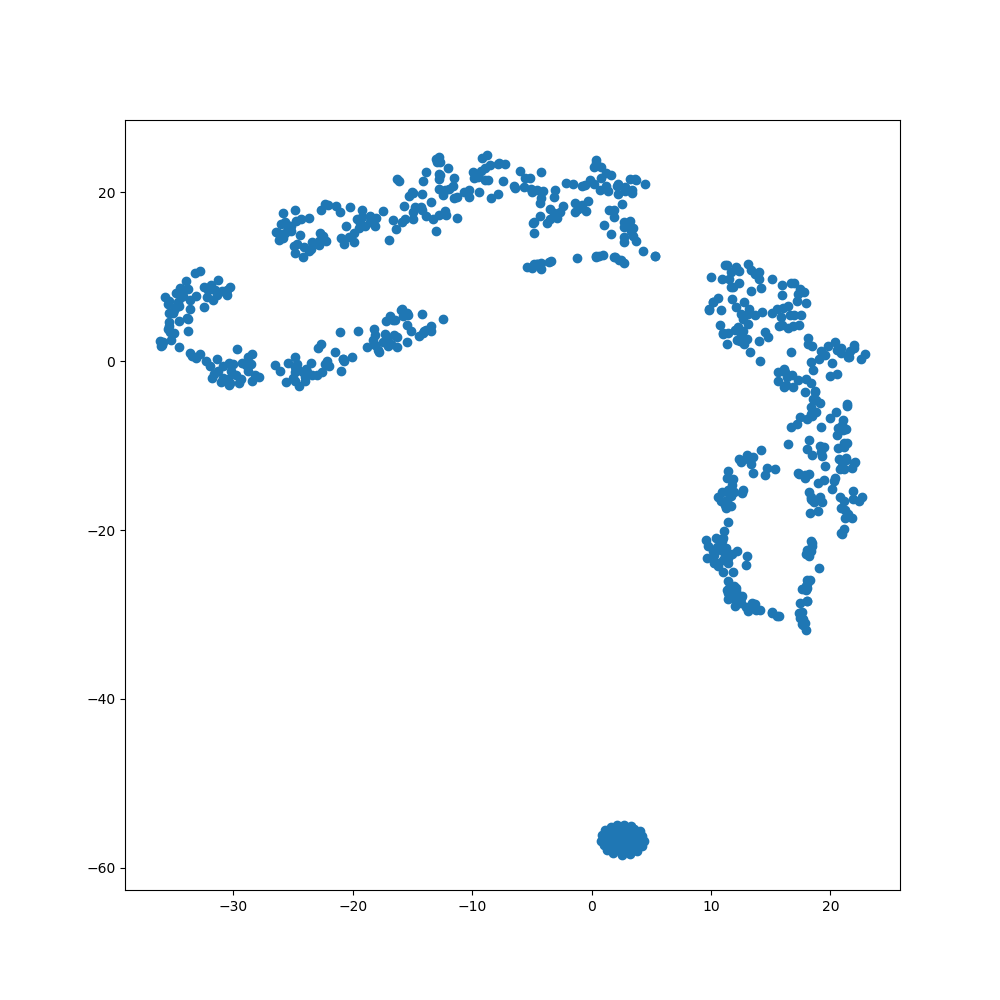

{'Coral': 1, 'Sediment': 2, 'Beach': 3, 'Seagrass': 4, 'Terrestrial vegetation': 5, 'Deep water': 6, 'Clouds': 7, 'Wave breaking': 8, 'Other or Unknown': 9}


In [9]:
# TSE
points, labels = Fiji.generate_randomized_points(100, consolidated = True)
tsne_results = TSNE(n_components=2).fit_transform(points)

fig = plt.figure(4,figsize=(10,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1])
plt.show()
# ax.imshow(truthmap[...,::-1])
# plt.show()
# print(np.asarray(cmap(0)[-2::-1])*255)
print(json_data["VedConsolidated_ClassDict"])
testdict = {'Reef Crest - coralline algae ridge': 263.83293861316076, 'Fore-reef deep slope': 70.06211128410703, 'Fore-reef shallow slope': 151.81276890771184, 'Fore-reef shallow terrace': 190.9951447921521, 'Fore-reef octocorals-dominated (Caribbean)': 0, 'Back-reef pavement': 23.805211835880574, 'Back-reef coral framework': 504.06732475209594, 'Back-reef coral bommies': 767.9690461410341, 'Back-reef octocorals-dominated (Caribbean)': 0, 'Lagoon Pinnacle reefs': 190.52354241167194, 'Lagoon Patch reefs': 2340.5541997121954, 'Lagoon Fringing reefs': 121.64149633228104, 'Lagoon Deep water': 114.45460804976489, 'Fore-reef sand flats': 372.9389698456479, 'Back-reef sediment-dominated': 500.2607762487424, 'Lagoon sediment apron - Barren': 4.634798906159125, 'Terrestrial Vegetated': 13.120074519621062, 'Terrestrial Mangroves': 1099.7360264110896, 'Intertidal Wetlands': 4164.279931145626, 'Beach (sand)': 1230.0551785450966, 'Beach (rock)': 0, 'Seagrass Meadows': 263.06976897868566, 'Deep Ocean Water': 2.060391359758762, 'Other': 8.73977287635436}

In [8]:
cmap = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                              'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
for i in range(len(cmap.colors)):
    print(np.asarray(np.asarray(cmap(i)[0:-1])*255, dtype=np.uint8))

[255 129 192]
[146 149 145]
[209 178 111]
[110 117  14]
[11 85  9]
[  3  67 223]
[206 162 253]
[  0 255 255]
[249 115   6]


<IPython.core.display.Javascript object>


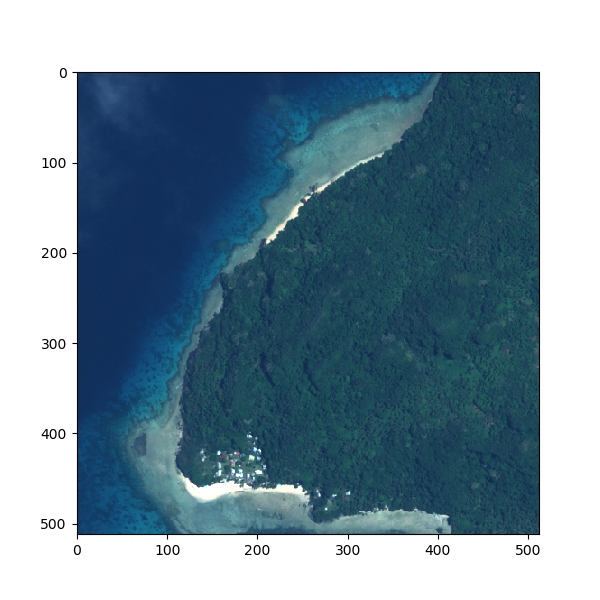

In [8]:
imagepath = 'C:/NeMO-Net Data/processed_Fiji_files'
specific_fn = 'Terrestrial vegetation_00000302.tif'
trainfile = 'C:/Users/asli/Documents/GitHub/NeMO-NET/Images/Fiji_RGB_Patches_512/rastertrain.txt'
image_size = 512

patch = coralutils.load_specific_patch(imagepath, specific_fn, trainfile, image_size)
patch_R = 255/200*patch[:,:,4]
patch_G = 255/200*patch[:,:,2]
patch_B = 255/200*patch[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
patch_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
fig = plt.figure(10,figsize=(6,6))
ax = plt.subplot(111)
ax.imshow(patch_RGB)
plt.show()


In [6]:
print(patch[:,:,4])

[[ 33.65920258  13.25968552  13.25968552 ...,  29.57929802  26.00938416
   19.12454605]
 [ 50.99879074  16.82960129  12.74969769 ...,  26.26437759  21.16449738
   19.3795414 ]
 [ 24.98940659  16.82960129  12.74969769 ...,  18.10457039  23.96943092
   16.82960129]
 ..., 
 [ 17.08459473  16.82960129  14.78964901 ...,  30.0892868   30.59927368
   30.34428024]
 [ 17.59458351  16.82960129  14.02466774 ...,  30.0892868   29.32430458
   29.57929802]
 [ 18.10457039  19.3795414   18.86955261 ...,  30.0892868   29.32430458
   29.57929802]]
